# Regression Project

In this project, your goal is to build regression models of housing prices. The models should learn from data and be able to predict the median house price in a district (which is a population of 600 to 3000 people), given some predictor variables. 

# Mit welchem RMSE wäre ich zufrieden?

# Setup

### Import von benötigten Libraries

In [1]:
%matplotlib inline

# Allgemein
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse

# Einstellung für Visualisierungen
sns.set_theme(style="ticks", color_codes=True)


# Für sklearn pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import plotly.express as px

from patsy import dmatrix

from sklearn.preprocessing import SplineTransformer

import statsmodels.api as sm



### Erstellen der Pipeline für scikit learn Modelle

In [2]:
# for numeric features
#Normalisierung (X=(X-Mittelwert) / Standardabweichung)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

In [3]:
# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #Konstante bei fehlenden Werten reinschreiben
    ('onehot', OneHotEncoder(handle_unknown='ignore'))#pro Featureausprägung eine Spalte, zutreffendes Feature hat dann Wert 1 und die anderen Wert 0
    ])

In [4]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

# Import Data

Als nächstes wird der Datensatz aus dem GutHub Repository importiert

In [5]:
ROOT = "https://raw.githubusercontent.com/jan-kirenz/project-OliScha/main/"
DATA = "project_data.csv?token=GHSAT0AAAAAABPCEITIYHBIEPRTFMZJXUGKYPKREJQ"

df = pd.read_csv(ROOT + DATA)

In [6]:
# Prüfen ob Import funktioniert hat und ersten Blick auf Daten werfen
df

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88          41.0years          880           129.0   
1        -122.22     37.86               21.0         7099          1106.0   
2        -122.24     37.85               52.0         1467           190.0   
3        -122.25     37.85               52.0         1274           235.0   
4        -122.25     37.85               52.0         1627           280.0   
...          ...       ...                ...          ...             ...   
20635    -121.09     39.48               25.0         1665           374.0   
20636    -121.21     39.49               18.0          697           150.0   
20637    -121.22     39.43               17.0         2254           485.0   
20638    -121.32     39.43               18.0         1860           409.0   
20639    -121.24     39.37               16.0         2785           616.0   

       population  households  median_income median_house_value  \
0             322         126         8.3252          452600.0$   
1            2401        1138         8.3014           358500.0   
2             496         177         7.2574           352100.0   
3             558         219         5.6431           341300.0   
4             565         259         3.8462           342200.0   
...           ...         ...            ...                ...   
20635         845         330         1.5603            78100.0   
20636         356         114         2.5568            77100.0   
20637        1007         433         1.7000            92300.0   
20638         741         349         1.8672            84700.0   
20639        1387         530         2.3886            89400.0   

      ocean_proximity price_category  
0            NEAR BAY          above  
1            NEAR BAY          above  
2            NEAR BAY          above  
3            NEAR BAY          above  
4            NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[20640 rows x 11 columns]

# Data Split

The error rate on new cases is called the generalization error (or out-of-sample error), and by evaluating our model on the test set, we get an estimate of this error. This value tells you how well your model will perform on instances it has never seen before

*Im nächsten Schritt wird das df in Trainingsdaten und Testdaten aufgeteilt. Durch random state = 0 sind die Datensätze jederzeit replizierbar.*

In [7]:
# Data Split
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_dataset

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
14740    -117.05     32.58               22.0         2101           399.0   
10101    -117.97     33.92               32.0         2620           398.0   
20566    -121.84     38.65               29.0         3167           548.0   
2670     -115.60     33.20               37.0          709           187.0   
15709    -122.43     37.79               25.0         1637           394.0   
...          ...       ...                ...          ...             ...   
7616     -118.22     33.86               16.0         8732          1489.0   
8767     -118.39     33.81               35.0         1008           165.0   
16388    -121.30     38.05               52.0          122            26.0   
19949    -119.37     36.21               35.0         2228           476.0   
10078    -120.27     39.35               11.0         2520           401.0   

       population  households  median_income median_house_value  \
14740        1551         371         4.1518           136900.0   
10101        1296         429         5.7796           241300.0   
20566        1554         534         4.3487           200700.0   
2670          390         142         2.4511            72500.0   
15709         649         379         5.0049           460000.0   
...           ...         ...            ...                ...   
7616         3944        1493         5.1948           203500.0   
8767          391         167         3.7778           487500.0   
16388          62          25         1.1500           112500.0   
19949        1567         449         1.4455            54100.0   
10078         397         165         4.6650           145600.0   

      ocean_proximity price_category  
14740      NEAR OCEAN          below  
10101       <1H OCEAN          above  
20566          INLAND          above  
2670           INLAND          above  
15709        NEAR BAY          above  
...               ...            ...  
7616        <1H OCEAN          above  
8767       NEAR OCEAN          above  
16388          INLAND          below  
19949          INLAND          above  
10078          INLAND          below  

[16512 rows x 11 columns]

# Data Inspection 

In [8]:
# Datentypen und fehlende Werte prüfen
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14740 to 10078
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  object 
 3   total_rooms         16512 non-null  int64  
 4   total_bedrooms      16352 non-null  float64
 5   population          16512 non-null  int64  
 6   households          16512 non-null  int64  
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  object 
 9   ocean_proximity     16512 non-null  object 
 10  price_category      16512 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.5+ MB


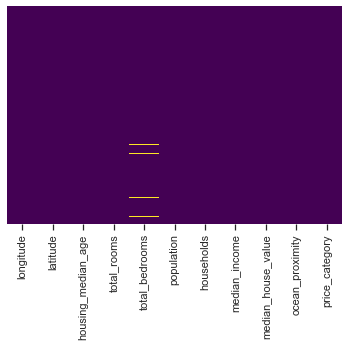

In [9]:
# Identifizieren der NULL Werte via Heatmap
sns.heatmap(train_dataset.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [10]:
# Identifizieren der NULL Werte via Liste
print(train_dataset.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        160
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


In den vorherigen Schritten kann erkannt werden, das für das Attribut total_bedrooms 207 Null Values vorliegen. alle anderen Attribute sind vollständig

*Anhand der hier abgebildeten Untersuchung kann erkannt werden, dass die Variable "total_bedrooms" in 207 Observations leer ist. Die hier entdeckten Anomalien werden später unter Feature Engineering entfernt.*

# Deskriptive Statistik

In [11]:
# summary statistics for all numerical columns
round(df.describe(),1).transpose()

count    mean     std    min     25%     50%     75%  \
longitude       20640.0  -119.6     2.0 -124.4  -121.8  -118.5  -118.0   
latitude        20640.0    35.6     2.1   32.5    33.9    34.3    37.7   
total_rooms     20640.0  2635.8  2181.6    2.0  1447.8  2127.0  3148.0   
total_bedrooms  20433.0   537.9   421.4    1.0   296.0   435.0   647.0   
population      20640.0  1425.5  1132.5    3.0   787.0  1166.0  1725.0   
households      20640.0   499.5   382.3    1.0   280.0   409.0   605.0   
median_income   20640.0     3.9     1.9    0.5     2.6     3.5     4.7   

                    max  
longitude        -114.3  
latitude           42.0  
total_rooms     39320.0  
total_bedrooms   6445.0  
population      35682.0  
households       6082.0  
median_income      15.0

Die Zeilen mit 25 %, 50 % und 75 % zeigen die entsprechenden Perzentile: EinPerzentil besagt, dass ein bestimmter prozentualer Anteil der Beobachtungenunterhalb eines Werts liegt. Beispielsweise haben 25 % der Bezirke ein housing_median_age unter 18, 50 % liegen unter 29, und 75 % liegen unter 37. Diese nenntman oft das 25. Perzentil (oder 1. Quartil), den Median und das 75. Perzentil(oder 3. Quartil)

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

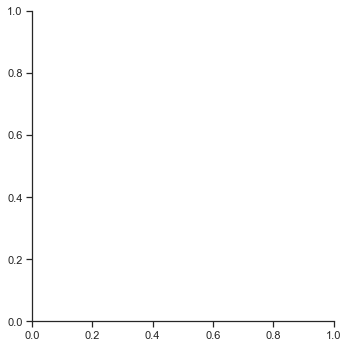

In [12]:
sns.displot(data=df, x="median_house_value", kind="kde" )

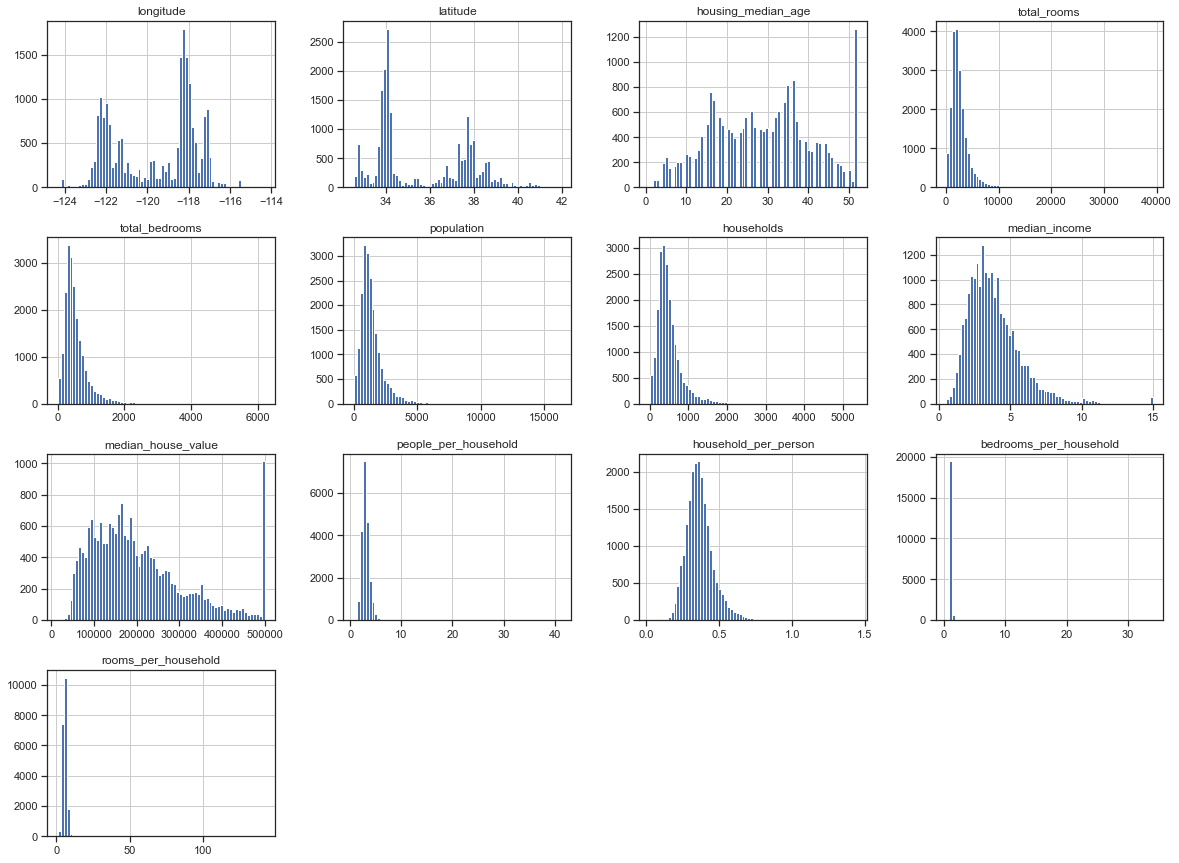

In [112]:

df.hist(bins=70, figsize=(20,15))
plt.show()

# Exploratory Data Analysis

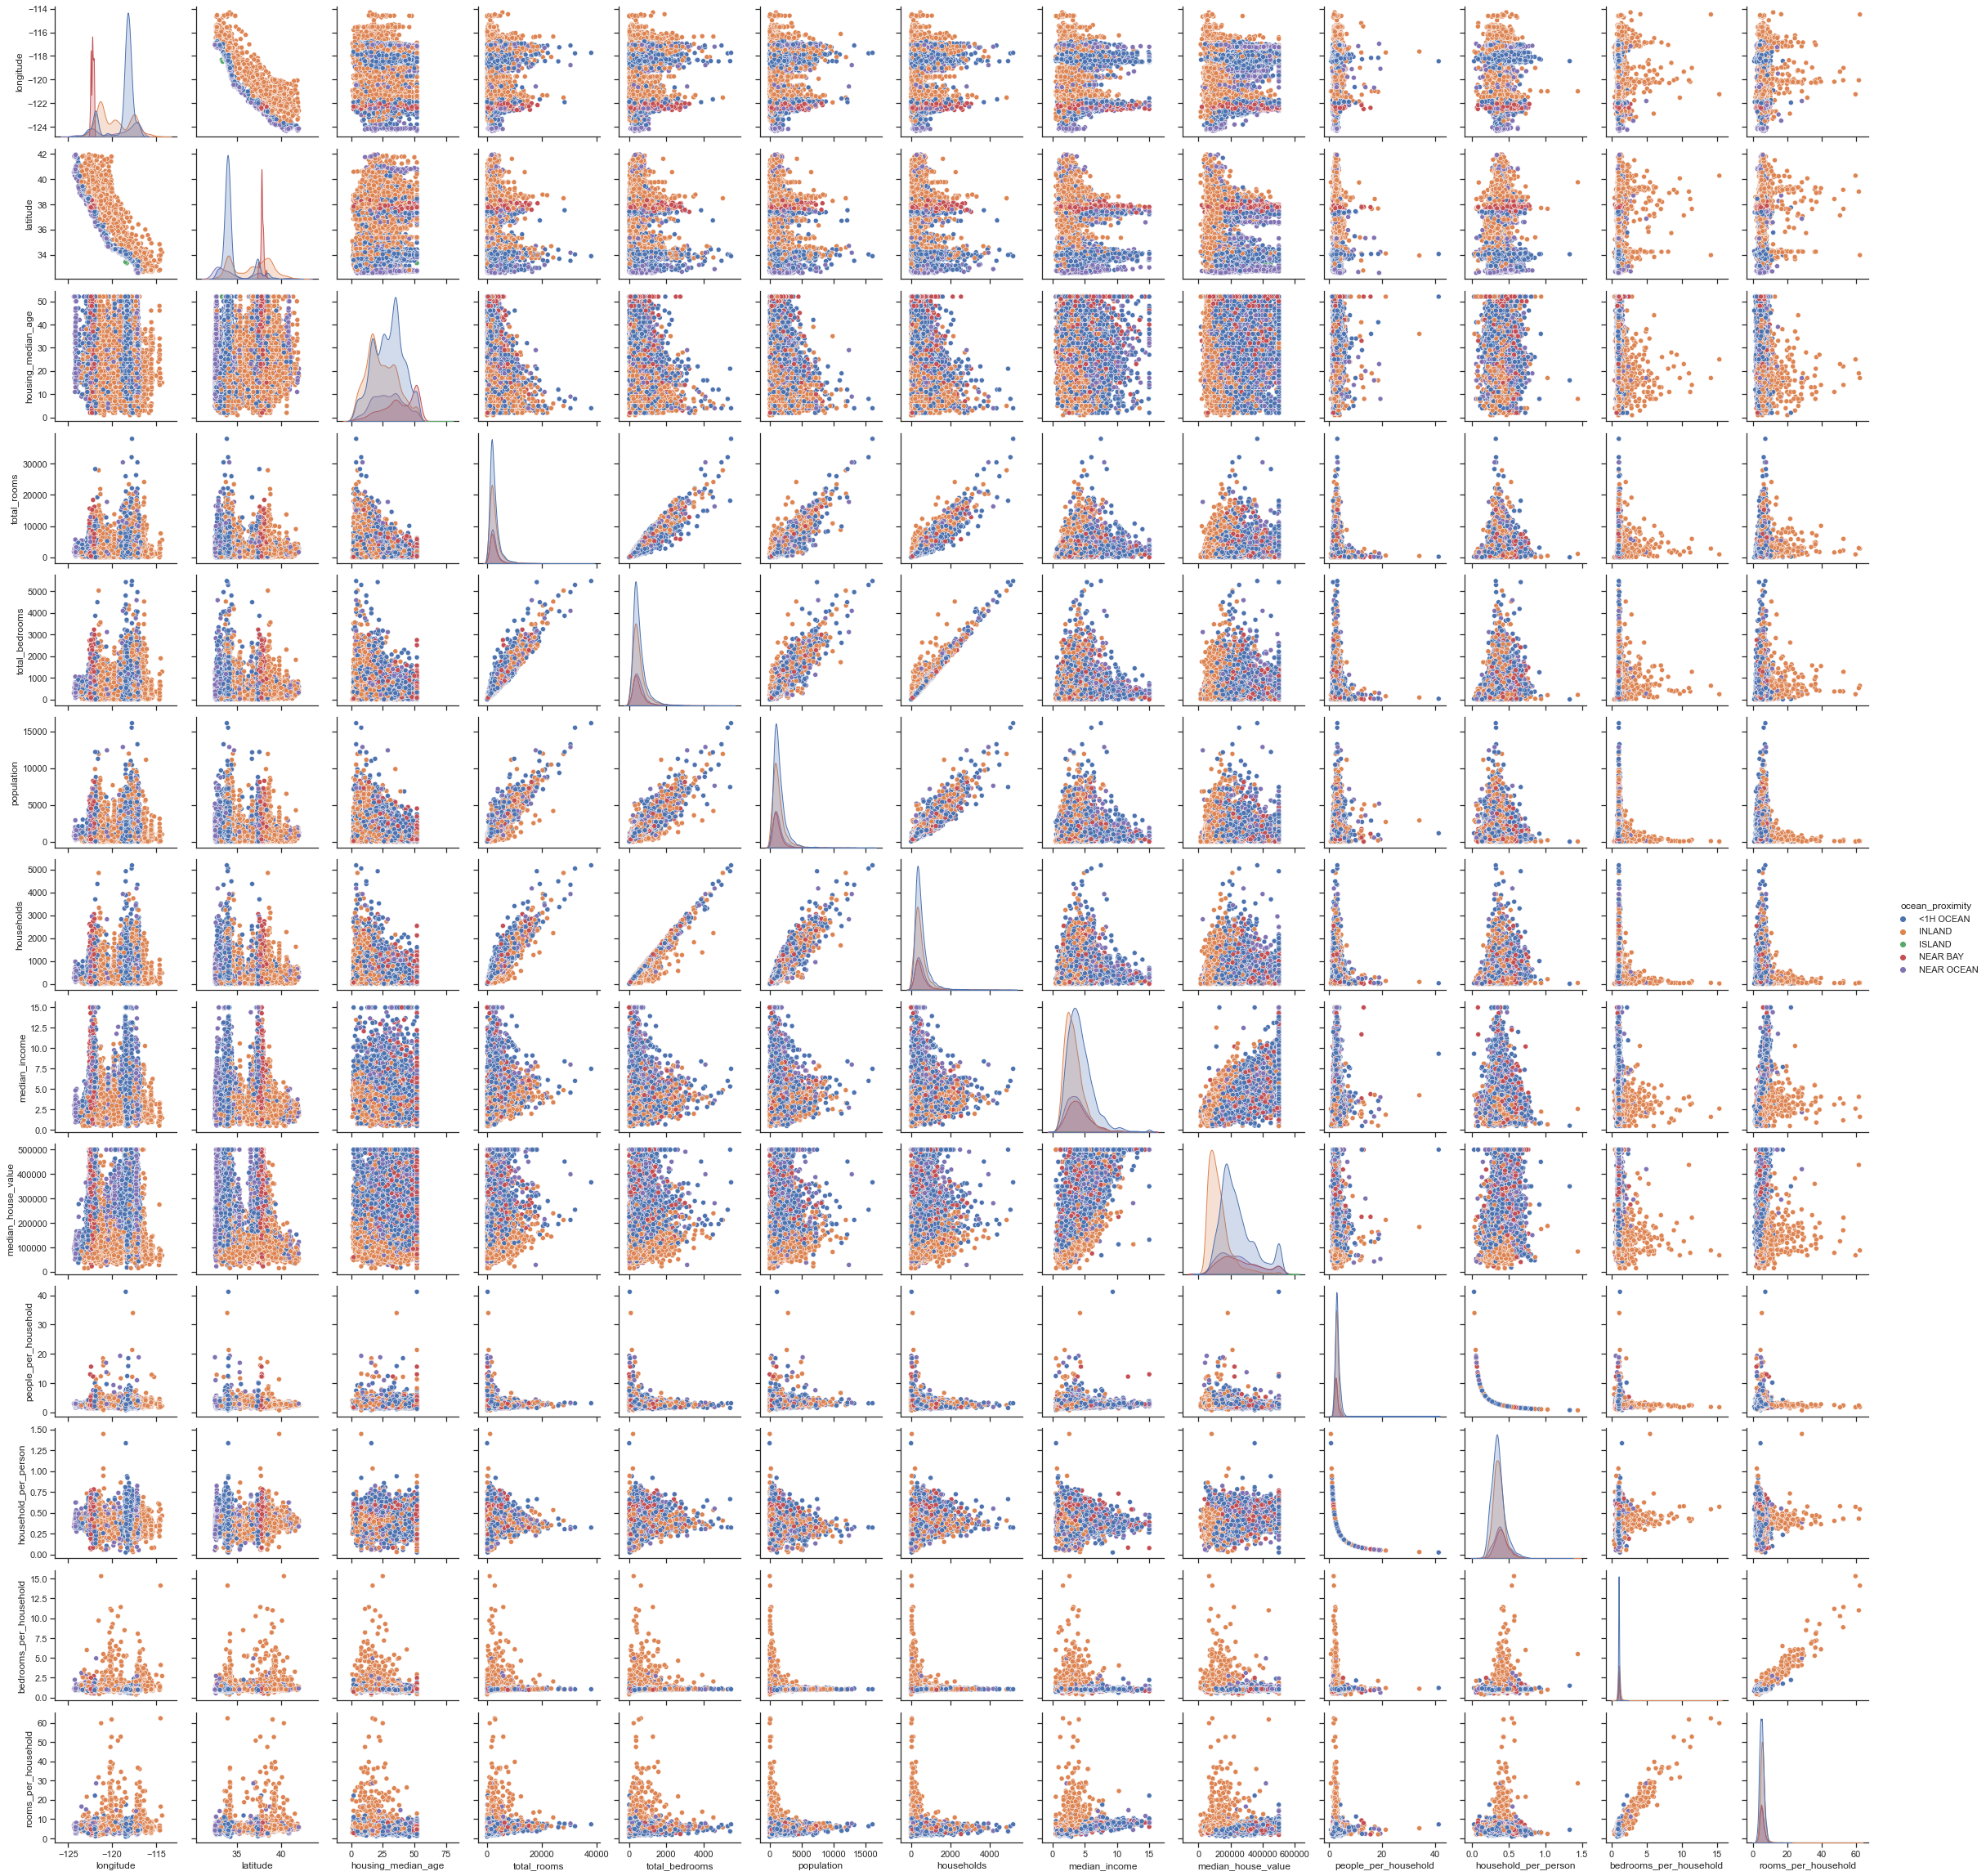

In [134]:
#nimmt nur numerische variablen
sns.pairplot(data=train_dataset, hue="ocean_proximity");

***Erkenntnis:** Ein Zusammenhang zwischen Income und house value ist zu erkennen, ansonstn keine offensichtlichen Zusammenhänge.  
Lineare Zusammenhänge zwischen rooms, bedrooms, households und population sind logisch und müssen bei der Modellierung später beachtet werden (Collinearity).*

In [68]:
corr = train_dataset.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.690796
household_per_person      0.263035
rooms_per_household       0.165391
total_rooms               0.135640
housing_median_age        0.109786
households                0.066077
total_bedrooms            0.049908
population               -0.026873
longitude                -0.047459
bedrooms_per_household   -0.066208
latitude                 -0.142811
people_per_household     -0.208637
Name: median_house_value, dtype: float64

---

#### **EDA - Analyse kategorialer Varaiblen**

*Als nächstes werden die kategorialen Variablen näher untersucht. Im Datensatz gibt es lediglich zwei kategoriale Variablen, "ocean_proximity" und "price_category". Da sich die Variable "price_category" direkt von der vorherzusagenden Variablen "median_house_value" ableitet, ist diese nicht zur Vorhersage geeignet und wird daher nicht weiter beachtet.*

In [69]:
train_dataset['ocean_proximity'].value_counts()

<1H OCEAN     7211
INLAND        5209
NEAR OCEAN    2112
NEAR BAY      1802
ISLAND           5
Name: ocean_proximity, dtype: int64

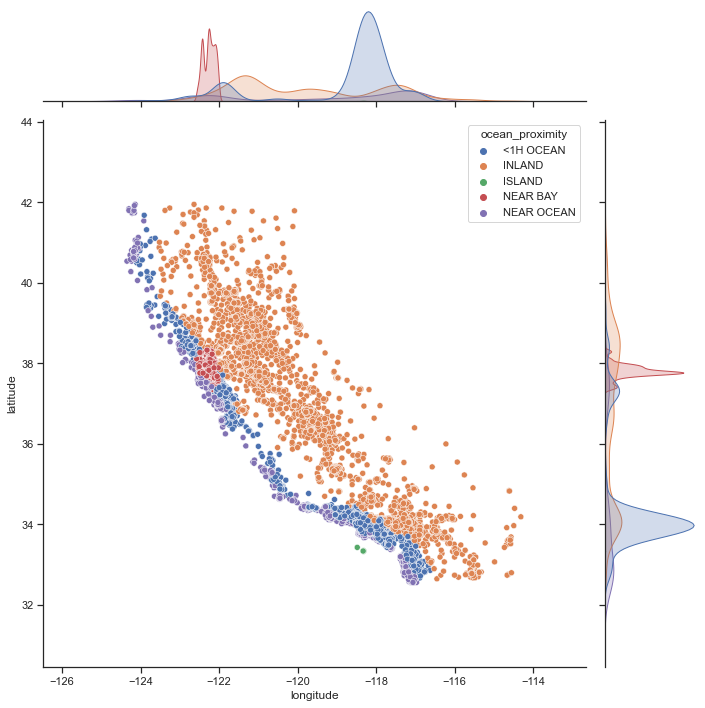

In [115]:
# Verteilung von ocean_proximity auf Geokoordinaten visualisieren
sns.jointplot(data=train_dataset, x='longitude', y='latitude', hue="ocean_proximity",height=10);


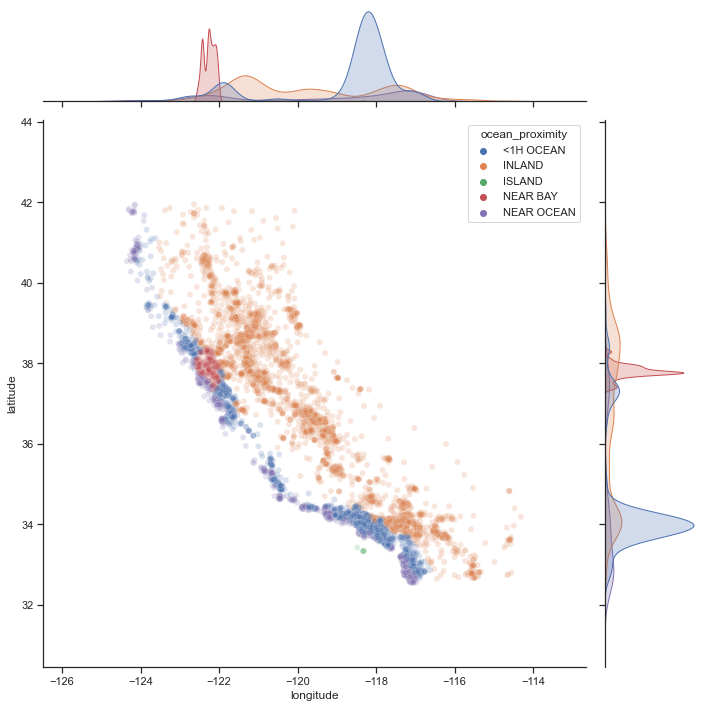

In [121]:
# Visualisierung Dichte
sns.jointplot(data=train_dataset, x='longitude', y='latitude', hue="ocean_proximity",height=10, alpha=0.2 );

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


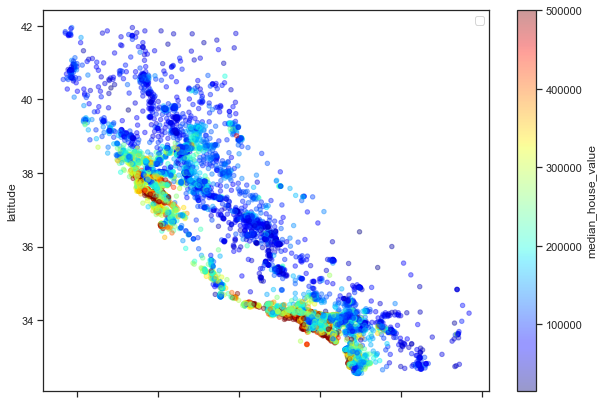

In [133]:
train_dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

*Auf der Karte (Kalifornien) lässt sich eine klare Verteilung der Variablen "ocean_proximity" erkennen. Die Ausprägungen "Island" und "Near Bay" liegen nur an jeweils einer bestimmten Stelle auf der Karte vor.*

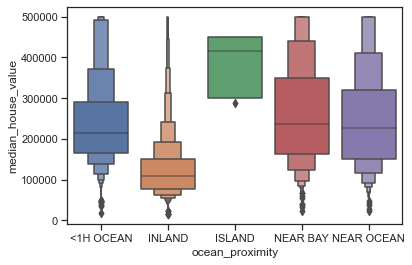

In [71]:
# Untersuchung der kategroialen Variable "ocean_proximity" mit einem erweiterten Boxplot
sns.boxenplot(data=train_dataset, x="ocean_proximity", y="median_house_value");

*Im Boxplot Diagramm lassen sich bereits einige Outlier erkennen, welche sich am unteren Wertebereich von "median_house_value" befinden.*

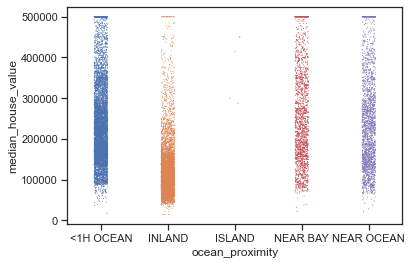

In [72]:
# Ergänzung zum Boxplot um Menge und Dichte der Observations zu visualisieren
sns.stripplot(data=train_dataset, x="ocean_proximity", y="median_house_value" , size=1 );

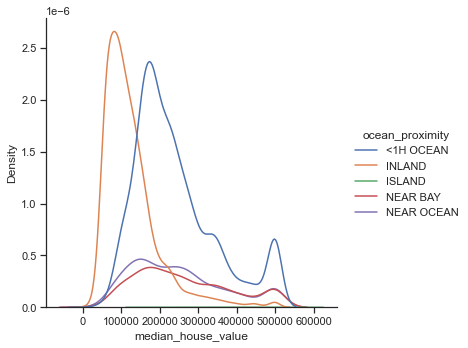

In [73]:
# Analyse von "ocean_proximity" mit displot
sns.displot(data=train_dataset, x="median_house_value", hue = "ocean_proximity", kind="kde" )

>***Fazit:** "ocean_proximity" hat definitiv Einfluss auf unsere vorherzusagende Variable. Inland ist bspw. tenedneziell günstiger als die anderen Ausprägungen.   
Auffällig ist, das es für die Ausprägung Island nur sehr wenige Observations gibt und Island und Near Bay stark auf lokale Gebiete beschränkt sind (siehe Karte).*

---

#### **EDA - Analyse numerischer Varaiblen**

*Vor allem die numerische Variable "median_income" sieht auf Basis des zu Beginn erstellen pairplots vielversprechend aus und wird daher nun näher untersucht. Aber auch andere numerische Varaiblen sollen noch genauer betrachtet werden.*

In [74]:
# Grouped summary statistics for all numerical columns (in transposed view)
train_dataset.groupby(["ocean_proximity"]).describe().T

ocean_proximity              <1H OCEAN       INLAND      ISLAND     NEAR BAY  \
longitude           count  7211.000000  5209.000000    5.000000  1802.000000   
                    mean   -118.842258  -119.724281 -118.354000  -122.264506   
                    std       1.584648     1.896371    0.070569     0.148030   
                    min    -124.140000  -123.530000 -118.480000  -122.590000   
                    25%    -118.495000  -121.340000 -118.330000  -122.410000   
...                                ...          ...         ...          ...   
rooms_per_household min       0.846154     1.550409    4.138728     1.824719   
                    25%       4.231236     4.867500    5.060423     4.427575   
                    50%       5.058925     5.495446    5.473318     5.075336   
                    75%       5.953044     6.204188    6.225000     5.905523   
                    max      22.222222    62.422222    7.385417     9.802326   

ocean_proximity             NEAR OCEAN  
longitude           count  2112.000000  
                    mean   -119.330251  
                    std       2.329356  
                    min    -124.350000  
                    25%    -122.020000  
...                                ...  
rooms_per_household min       1.968051  
                    25%       4.224502  
                    50%       5.125758  
                    75%       6.015899  
                    max      28.600000  

[104 rows x 5 columns]

In [75]:
round(train_dataset.describe(),2).T

count       mean        std       min        25%  \
longitude               16339.0    -119.56       2.00   -124.35    -121.79   
latitude                16339.0      35.63       2.14     32.55      33.93   
housing_median_age      16339.0      28.63      12.60      1.00      18.00   
total_rooms             16339.0    2623.28    2126.35      6.00    1453.00   
total_bedrooms          16339.0     535.25     410.92      1.00     297.00   
population              16339.0    1416.02    1071.59      3.00     787.00   
households              16339.0     496.71     372.69      1.00     281.00   
median_income           16339.0       3.88       1.90      0.50       2.56   
median_house_value      16339.0  207197.92  115876.63  14999.00  119600.00   
people_per_household    16339.0       2.94       0.97      0.69       2.43   
household_per_person    16339.0       0.36       0.09      0.02       0.30   
bedrooms_per_household  16339.0       1.10       0.40      0.38       1.01   
rooms_per_household     16339.0       5.44       2.18      0.85       4.45   

                              50%        75%        max  
longitude                 -118.49    -118.00    -114.31  
latitude                    34.25      37.71      41.95  
housing_median_age          29.00      37.00      52.00  
total_rooms               2120.00    3127.00   37937.00  
total_bedrooms             434.00     644.00    5471.00  
population                1163.00    1720.00   16122.00  
households                 408.00     601.00    5189.00  
median_income                3.54       4.75      15.00  
median_house_value      179200.00  265950.00  500001.00  
people_per_household         2.82       3.29      41.21  
household_per_person         0.35       0.41       1.44  
bedrooms_per_household       1.05       1.10      15.31  
rooms_per_household          5.24       6.05      62.42

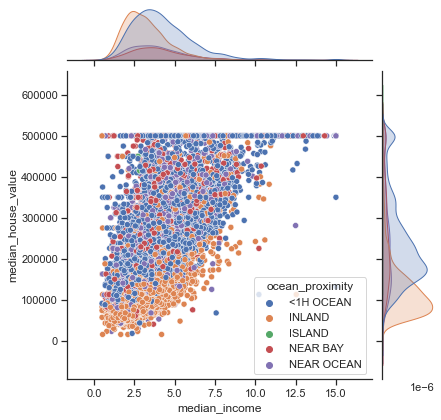

In [76]:
# Analyse der Variablen "median_income"
sns.jointplot(data=train_dataset, x='median_income', y='median_house_value', hue="ocean_proximity", );

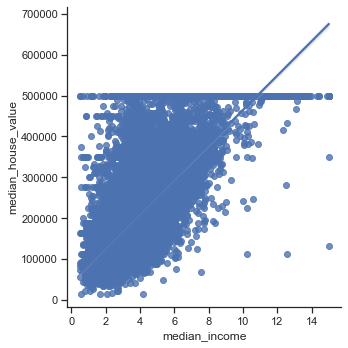

In [77]:
sns.lmplot(data=train_dataset, x='median_income', y='median_house_value');

**Analyse "household_per_person"**

<AxesSubplot:xlabel='household_per_person', ylabel='median_house_value'>

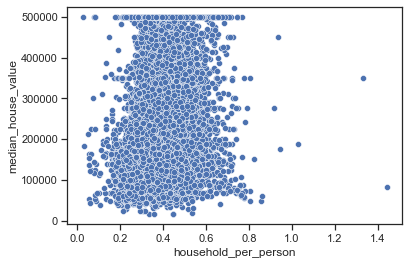

In [78]:
sns.scatterplot(data=train_dataset, x='household_per_person', y='median_house_value')

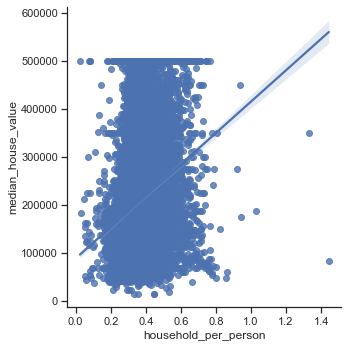

In [79]:
sns.lmplot(data=train_dataset, x='household_per_person', y='median_house_value');

**Analyse "rooms_per_household"**

<AxesSubplot:xlabel='rooms_per_household', ylabel='median_house_value'>

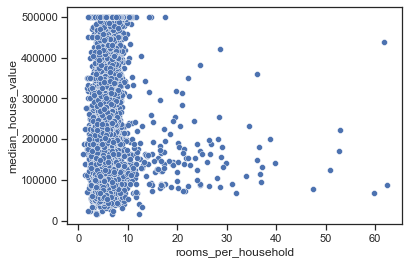

In [80]:
sns.scatterplot(data=train_dataset, x='rooms_per_household', y='median_house_value')

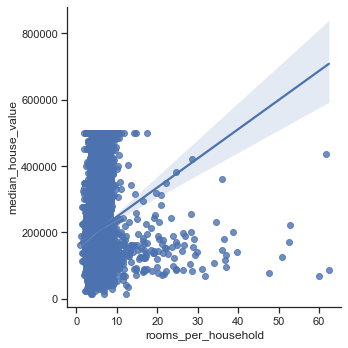

In [81]:
sns.lmplot(data=train_dataset, x='rooms_per_household', y='median_house_value');

**Analyse "housing_median_age"**

<AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>

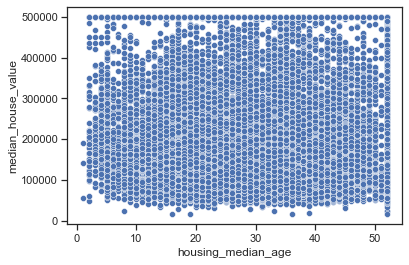

In [82]:
sns.scatterplot(data=train_dataset, x='housing_median_age', y='median_house_value')

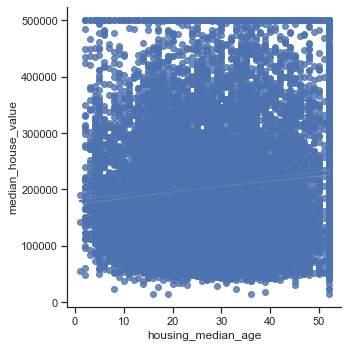

In [83]:
sns.lmplot(data=train_dataset, x='housing_median_age', y='median_house_value');

#### **Correlation**

In [84]:
# Create correlation matrix for numerical variables
corr_matrix = train_dataset.corr()
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude                1.000000 -0.924162           -0.109765     0.049214   
latitude                -0.924162  1.000000            0.010871    -0.038576   
housing_median_age      -0.109765  0.010871            1.000000    -0.358937   
total_rooms              0.049214 -0.038576           -0.358937     1.000000   
total_bedrooms           0.075765 -0.071595           -0.318286     0.928399   
population               0.109251 -0.117794           -0.300734     0.863667   
households               0.062156 -0.077228           -0.299495     0.916751   
median_income           -0.016895 -0.079124           -0.114836     0.201362   
median_house_value      -0.047459 -0.142811            0.109786     0.135640   
people_per_household     0.134256 -0.130333            0.000160    -0.109974   
household_per_person    -0.138509  0.120870            0.024449     0.076010   
bedrooms_per_household   0.019678  0.078912           -0.101127     0.040937   
rooms_per_household     -0.031336  0.120070           -0.181565     0.158909   

                        total_bedrooms  population  households  median_income  \
longitude                     0.075765    0.109251    0.062156      -0.016895   
latitude                     -0.071595   -0.117794   -0.077228      -0.079124   
housing_median_age           -0.318286   -0.300734   -0.299495      -0.114836   
total_rooms                   0.928399    0.863667    0.916751       0.201362   
total_bedrooms                1.000000    0.886206    0.978400      -0.008631   
population                    0.886206    1.000000    0.917338       0.003006   
households                    0.978400    0.917338    1.000000       0.013337   
median_income                -0.008631    0.003006    0.013337       1.000000   
median_house_value            0.049908   -0.026873    0.066077       0.690796   
people_per_household         -0.140112    0.156216   -0.124652      -0.051023   
household_per_person          0.154664   -0.187900    0.131059      -0.007098   
bedrooms_per_household        0.061178   -0.083340   -0.066871      -0.077353   
rooms_per_household           0.004549   -0.089146   -0.094716       0.371443   

                        median_house_value  people_per_household  \
longitude                        -0.047459              0.134256   
latitude                         -0.142811             -0.130333   
housing_median_age                0.109786              0.000160   
total_rooms                       0.135640             -0.109974   
total_bedrooms                    0.049908             -0.140112   
population                       -0.026873              0.156216   
households                        0.066077             -0.124652   
median_income                     0.690796             -0.051023   
median_house_value                1.000000             -0.208637   
people_per_household             -0.208637              1.000000   
household_per_person              0.263035             -0.784152   
bedrooms_per_household           -0.066208             -0.067947   
rooms_per_household               0.165391             -0.057770   

                        household_per_person  bedrooms_per_household  \
longitude                          -0.138509                0.019678   
latitude                            0.120870                0.078912   
housing_median_age                  0.024449               -0.101127   
total_rooms                         0.076010                0.040937   
total_bedrooms                      0.154664                0.061178   
population                         -0.187900               -0.083340   
households                          0.131059               -0.066871   
median_income                      -0.007098               -0.077353   
median_house_value                  0.263035               -0.066208   
people_per_household               -0.784152               -0.067947   
household_per_person   

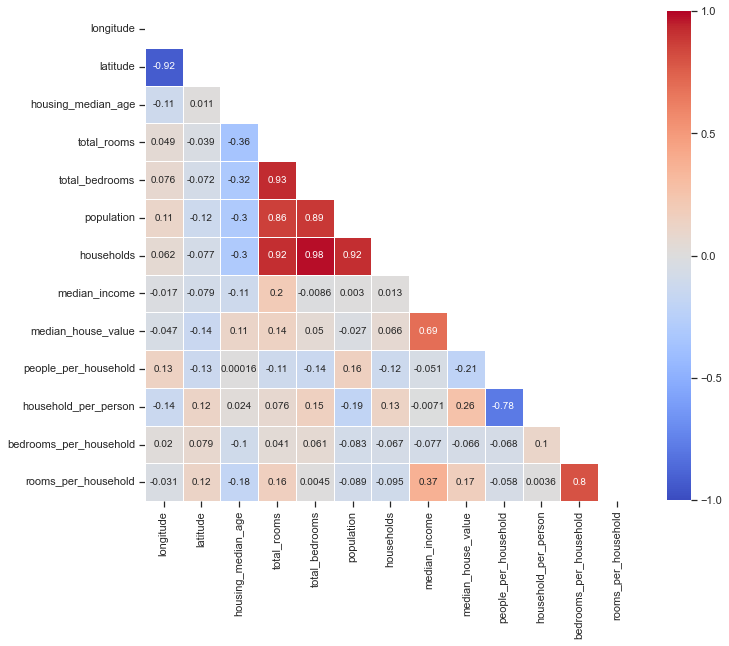

In [85]:
# Erstellen einer Heatmap um Abhängigkeiten zwischen den verschiedenen Variablen zu visualisieren

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Erstellen der Heatmap mit zusätzlichen Parametern
plt.subplots(figsize=(11, 15))
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

# Initial Feature Engineering

In [149]:
# create new, more relevant variables
train_dataset=train_dataset.assign(people_per_household=lambda train_dataset: train_dataset.population/train_dataset.households)
train_dataset=train_dataset.assign(household_per_person=lambda train_dataset: train_dataset.households/train_dataset.population)
train_dataset=train_dataset.assign(bedrooms_per_household=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.households)
train_dataset=train_dataset.assign(rooms_per_household=lambda train_dataset: train_dataset.total_rooms/train_dataset.households)
train_dataset=train_dataset.assign(bedrooms_per_room=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.total_rooms)

In [150]:
# create new, more relevant variables
test_dataset=test_dataset.assign(people_per_household=lambda test_dataset: test_dataset.population/test_dataset.households)
test_dataset=test_dataset.assign(household_per_person=lambda test_dataset: test_dataset.households/test_dataset.population)
test_dataset=test_dataset.assign(bedrooms_per_household=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.households)
test_dataset=test_dataset.assign(rooms_per_household=lambda test_dataset: test_dataset.total_rooms/test_dataset.households)
test_dataset=test_dataset.assign(bedrooms_per_room=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.total_rooms)


In [151]:
# drop remaining row with one missing value
train_dataset = train_dataset.dropna()

In [152]:
#drop population outlier
train_dataset=train_dataset.drop([15360, 9880])
#drop people_per_household outlier
train_dataset=train_dataset.drop([19006, 16669, 13034, 3364, 9172, 12104, 16420])

KeyError: '[15360] not found in axis'

In [153]:
# change datatype zu string um str.replace transformation durchzuführen
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("string")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("string")

In [154]:
# Bereinigung der "fehlerhaften" Werte
train_dataset.median_house_value = train_dataset.median_house_value.str.replace("$", "", regex =True)
train_dataset.housing_median_age = train_dataset.housing_median_age.str.replace("years", "", regex =True)

In [155]:
# data type anpassen
# value oder age könnte auch float sein, hier aber für int entschieden da keine Nachkommastellen vorhanden 
# ocean proximity und price category bleiben object, da categroical values ohne order, mit meaning und nur string
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("float64")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("float64")
train_dataset['total_bedrooms'] = train_dataset['total_bedrooms'].astype("int64")
train_dataset['ocean_proximity'] = train_dataset['ocean_proximity'].astype("category")
train_dataset['price_category'] = train_dataset['price_category'].astype("category")

In [156]:
# summary statistics for all categorical/object columns
train_dataset.describe(include=['category']).transpose()

count unique        top   freq
ocean_proximity  16352      5  <1H OCEAN   7225
price_category   16352      2      above  13199

In [157]:
corr = train_dataset.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.686220
household_per_person      0.266171
rooms_per_household       0.138533
total_rooms               0.131430
housing_median_age        0.107960
households                0.064087
total_bedrooms            0.048334
people_per_household     -0.021874
population               -0.028566
longitude                -0.044550
bedrooms_per_household   -0.047168
latitude                 -0.146066
bedrooms_per_room        -0.253441
Name: median_house_value, dtype: float64

# Modelling

## 1. Linear OLS Regression

In [158]:
# Select features for simple regression
features = ['median_income', 'household_per_person', 'ocean_proximity', 'rooms_per_household', 'housing_median_age']
X1 = train_dataset[features]

# Create response
y1 = train_dataset["median_house_value"]

### Model 1.1 - Linear OLS Regression with sklearn

In [159]:

# Data Split für Modell Scikitlearn
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [160]:
# Create pipeline with model
lin_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lin', LinearRegression())
                        ])

In [161]:
# show pipeline
set_config(display="diagram")
# Fit model
lin_pipe.fit(X_train1, y_train1)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E76F8F880>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E76F8F760>)])),
                ('lin', LinearRegression())])

In [162]:
# Obtain model coefficients
lin_pipe.named_steps['lin'].coef_

array([ 72032.60849607,  28483.62374275,    921.78833357,  12054.20051743,
       -20043.94030758, -93478.81535555, 150582.30222604, -22632.25997908,
       -14427.28658384])

In [163]:
# get absolute values of coefficients
importance = np.abs(lin_pipe.named_steps['lin'].coef_)

sns.barplot(x=importance, 
            y=list_numerical);

NameError: name 'list_numerical' is not defined

#### Evaluation with Test Data

In [ ]:
y_pred1 = lin_pipe.predict(X_test1)

In [ ]:
r2_score(y_test1, y_pred1)

0.6440749956216951

#### Evaluate with Training data

In [ ]:
y_pred1train = lin_pipe.predict(X_train1)

In [ ]:
y_pred1train

array([275757.06485042, 267476.10000415, 628514.08957977, ...,
       123975.4545491 , 157412.95242652, 210577.37843559])

In [ ]:
r2_score(y_train1, y_pred1train)  

0.660905216524134

Ergebnis mit Top 4 features ['median_income', 'household_per_person', 'ocean_proximity', 'room_per_person'] : r2 = 0.6514777282231453
+ housing_median_age = 0.660916387867293

In [ ]:
mean_squared_error(y_train1, y_pred1train)

4559576385.898086

In [ ]:
# RMSE
mean_squared_error(y_train1, y_pred1train, squared=False)

67524.6353999641

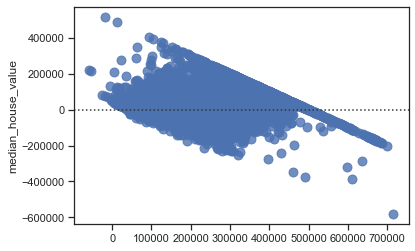

In [ ]:
sns.residplot(x=y_pred1train, y=y_train1, scatter_kws={"s": 80});

#### Evaluation with Test Data

In [ ]:
y_pred1test = lin_pipe.predict(X_test1)

In [ ]:
print('MSE:', mean_squared_error(y_test1, y_pred1test))

print('RMSE:', mean_squared_error(y_test1, y_pred1test, squared=False))

MSE: 4750668163.255863
RMSE: 68925.09095573152


In [ ]:

# Plot with Plotly Express
px.scatter(x=X_test1['median_income'], y=y_test1, opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

In [ ]:
import plotly.graph_objects as go

x_range = pd.DataFrame({ 'median_income': np.linspace(X_train['median_income'].min(), X_train['median_income'].max(), 100)})
y_range =  lin_pipe.predict(x_range)

go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range.median_income, y=y_range, name='prediction')
])


NameError: name 'X_train' is not defined

### Model 1.2 - Linear OLS Regression with Statsmodels

Im Folgenden wird die Lineare Regression mit Statsmodels einmal mit den klassischen Varaiblen und einmal mit selbst erstellten Varaiblen druchgeführt. Bei beiden Varianten werden mit Hilfe von Cook's Distance Outlier identifiziert und aus dem Modell entfernt.  
Dann soll vergleichen werden, welche Vorgehensweise zu einem besseren Ergebnis führt.

Backward / Forward Selection einbauen

#### Model mit Original Variablen

In [ ]:
# Fit Model with original features
lm1 = smf.ols(formula='median_house_value ~ median_income + housing_median_age + ocean_proximity + population + total_bedrooms', data=train_dataset2).fit()

In [ ]:
# Short summary
lm1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
# Full summary
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     3558.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:38:36   Log-Likelihood:            -2.0546e+05
No. Observations:               16339   AIC:                         4.109e+05
Df Residuals:                   16330   BIC:                         4.110e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      3.532e+04   2608.234     13.542      0.000    3.02e+04    4.04e+04
ocean_proximity[T.INLAND]     -7.296e+04   1351.523    -53.986      0.000   -7.56e+04   -7.03e+04
ocean_proximity[T.ISLAND]      1.633e+05   3.13e+04      5.213      0.000    1.02e+05    2.25e+05
ocean_proximity[T.NEAR BAY]    4741.7129   1901.465      2.494      0.013    1014.634    8468.792
ocean_proximity[T.NEAR OCEAN]  9668.0007   1740.243      5.556      0.000    6256.934    1.31e+04
median_income                  3.897e+04    302.573    128.795      0.000    3.84e+04    3.96e+04
housing_median_age             1214.8921     49.655     24.467      0.000    1117.563    1312.221
population                      -39.4971      1.115    -35.416      0.000     -41.683     -37.311
total_bedrooms                  118.3993      2.926     40.467      0.000     112.664     124.134
==============================================================================
Omnibus:                     3455.903   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10505.016
Skew:                           1.092   Prob(JB):                         0.00
Kurtosis:                       6.264   Cond. No.                     1.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation  

If Durbin–Watson is less than 1.0, there may be cause for concern.

Small values of d indicate successive error terms are positively correlated.

If d > 2, successive error terms are negatively correlated.

Omnisbus und JB kann bei großen Datensätzen vernachlässigt werden (SKript? Regression Diagnostics)

#### **Regression Diagnostics**

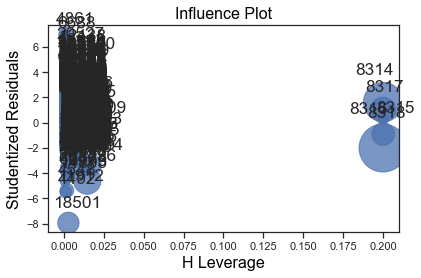

In [ ]:
# influence plot 
fig = sm.graphics.influence_plot(lm1, criterion="cooks")
fig.tight_layout(pad=1.0)

In [ ]:
# obtain Cook's distance 
lm1_cooksd = lm1.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(train_dataset2["median_income"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm1_cooksd > critical_d

# output potential outliers with leverage
print(train_dataset2.index[out_d], "\n", 
    lm1_cooksd[out_d])

Critical Cooks distance: 0.0002448130240528796
Int64Index([ 5300, 15413, 12377, 13958,  6024, 18904, 16906,  8846,  7357,
             8940,
            ...
             8867,   199, 18499, 16952,    59,  9810, 10752,  8858,  1601,
            18041],
           dtype='int64', length=957) 
 [0.00055053 0.00076178 0.00080329 0.00604638 0.00027508 0.00025655
 0.00029313 0.00132242 0.00025532 0.00031729 0.00121339 0.00064395
 0.00044116 0.00031568 0.01957591 0.00064359 0.00027662 0.00152719
 0.0005685  0.0019479  0.00057967 0.00032244 0.0007018  0.00065234
 0.00032382 0.00065263 0.0003474  0.00060354 0.00049622 0.00040568
 0.00098225 0.00035191 0.00101965 0.00071798 0.00039624 0.00027432
 0.00036073 0.00030557 0.00072637 0.00054968 0.00025036 0.00050458
 0.0010173  0.00075916 0.00062949 0.00061142 0.00093703 0.0026863
 0.00040669 0.00044602 0.00042028 0.00030663 0.00186755 0.00034386
 0.00083633 0.00024899 0.01523149 0.00186829 0.00043181 0.000559
 0.00071027 0.00028647 0.00033721 0.00024

In [ ]:
train_dataset2a=train_dataset2.drop(train_dataset.index[out_d])



In [ ]:
# Fit Model with original features
lm2 = smf.ols(formula='median_house_value ~ median_income + housing_median_age + ocean_proximity + population + total_bedrooms', data=train_dataset2a).fit()

In [ ]:
# Full summary
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     6103.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:11   Log-Likelihood:            -1.8932e+05
No. Observations:               15382   AIC:                         3.787e+05
Df Residuals:                   15374   BIC:                         3.787e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.386e+04   2183.914      6.345      0.000    9575.747    1.81e+04
ocean_proximity[T.INLAND]     -6.663e+04   1065.529    -62.534      0.000   -6.87e+04   -6.45e+04
ocean_proximity[T.ISLAND]     -2.765e-11   1.28e-11     -2.164      0.030   -5.27e-11   -2.61e-12
ocean_proximity[T.NEAR BAY]   -7079.2510   1549.788     -4.568      0.000   -1.01e+04   -4041.483
ocean_proximity[T.NEAR OCEAN]  5354.9973   1398.675      3.829      0.000    2613.428    8096.566
median_income                  4.192e+04    259.798    161.373      0.000    4.14e+04    4.24e+04
housing_median_age             1227.4471     40.279     30.474      0.000    1148.496    1306.398
population                      -42.6861      1.030    -41.436      0.000     -44.705     -40.667
total_bedrooms                  132.7850      2.816     47.157      0.000     127.266     138.304
==============================================================================
Omnibus:                      997.307   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.753
Skew:                           0.625   Prob(JB):                    8.36e-271
Kurtosis:                       3.615   Cond. No.                     5.29e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.81e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Model mit selbst erstellten Variablen

In [ ]:

lm3 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + household_per_person + rooms_per_household + housing_median_age', data=train_dataset2).fit()


In [ ]:
# Short summary
lm3.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

P < 0,05, dh wir können Null Hyptohese verwerfen, dh Zusammenhang ist da

In [ ]:
# Full summary
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     3922.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:50:48   Log-Likelihood:            -2.0494e+05
No. Observations:               16339   AIC:                         4.099e+05
Df Residuals:                   16330   BIC:                         4.100e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -6.018e+04   3130.220    -19.224      0.000   -6.63e+04    -5.4e+04
ocean_proximity[T.INLAND]     -7.192e+04   1345.205    -53.463      0.000   -7.46e+04   -6.93e+04
ocean_proximity[T.ISLAND]      1.632e+05   3.04e+04      5.378      0.000    1.04e+05    2.23e+05
ocean_proximity[T.NEAR BAY]   -2024.2754   1854.983     -1.091      0.275   -5660.245    1611.694
ocean_proximity[T.NEAR OCEAN]  3423.0784   1694.236      2.020      0.043     102.190    6743.967
median_income                  3.883e+04    321.493    120.776      0.000    3.82e+04    3.95e+04
household_per_person           3.073e+05   5803.288     52.950      0.000    2.96e+05    3.19e+05
rooms_per_household            -132.0086    275.124     -0.480      0.631    -671.282     407.265
housing_median_age              989.9966     45.395     21.808      0.000     901.017    1078.976
==============================================================================
Omnibus:                     2985.068   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10190.947
Skew:                           0.913   Prob(JB):                         0.00
Kurtosis:                       6.412   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lm4 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + household_per_person + housing_median_age', data=train_dataset2).fit()

In [ ]:
# obtain Cook's distance 
lm4_cooksd = lm4.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(train_dataset2["median_income"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm4_cooksd > critical_d

# output potential outliers with leverage
print(train_dataset2.index[out_d], "\n", 
    lm4_cooksd[out_d])

Critical Cooks distance: 0.0002448130240528796
Int64Index([ 5300, 17195, 16906,  8846, 18611,  8940,  4642, 15236, 14017,
            18501,
            ...
             8867,   199, 16952,    59,  9810, 10752,  8858,  1601, 15871,
            18041],
           dtype='int64', length=1026) 
 [0.00041711 0.00025574 0.00033999 ... 0.00025265 0.0005765  0.00031429]


In [ ]:
train_dataset2b=train_dataset2.drop(train_dataset2.index[out_d])

In [ ]:
lm4 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + household_per_person + housing_median_age', data=train_dataset2b).fit()

In [ ]:
lm4.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     7856.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:52   Log-Likelihood:            -1.8778e+05
No. Observations:               15313   AIC:                         3.756e+05
Df Residuals:                   15306   BIC:                         3.756e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -6.498e+04   2466.163    -26.348      0.000   -6.98e+04   -6.01e+04
ocean_proximity[T.INLAND]     -6.878e+04   1011.419    -68.000      0.000   -7.08e+04   -6.68e+04
ocean_proximity[T.ISLAND]     -4.961e-10   8.51e-12    -58.300      0.000   -5.13e-10   -4.79e-10
ocean_proximity[T.NEAR BAY]   -1.138e+04   1501.266     -7.578      0.000   -1.43e+04   -8434.585
ocean_proximity[T.NEAR OCEAN]  1833.7382   1354.601      1.354      0.176    -821.440    4488.917
median_income                  4.073e+04    249.048    163.560      0.000    4.02e+04    4.12e+04
household_per_person           2.925e+05   5006.509     58.432      0.000    2.83e+05    3.02e+05
housing_median_age              865.5206     36.159     23.937      0.000     794.645     936.397
==============================================================================
Omnibus:                      715.342   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              838.254
Skew:                           0.525   Prob(JB):                    9.45e-183
Kurtosis:                       3.458   Cond. No.                     2.48e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.42e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
print("SSR:", lm4.ssr)
print("MSE:", lm4.mse_resid)
print("RMSE", np.sqrt(lm4.mse_resid))

SSR: 40147229403291.96
MSE: 2622973304.801513
RMSE 51214.97149078103


In [ ]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset2b['y_pred2'] = lm4.predict()

In [ ]:
# MSE
mse(train_dataset2b['median_house_value'], train_dataset2b['y_pred2'])

2621774270.4428887

In [ ]:
y_pred2 = lm4.predict(X_test1)

In [ ]:
r2_score(y_test1, y_pred2)

0.6405490062827732

#### Regression Diagnostics

In [ ]:
# Plot regression line 
plt.scatter(train_dataset2b['median_income'], train_dataset2b['median_house_value'],  color='black')
plt.plot(train_dataset2b['median_income'], train_dataset2b['y_pred2'], color='darkred', linewidth=3);

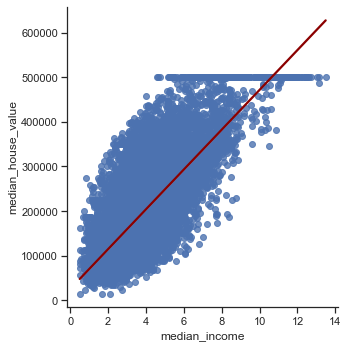

In [ ]:
sns.lmplot(x='median_income', y='median_house_value', data=train_dataset2b, line_kws={'color': 'darkred'}, ci=False);

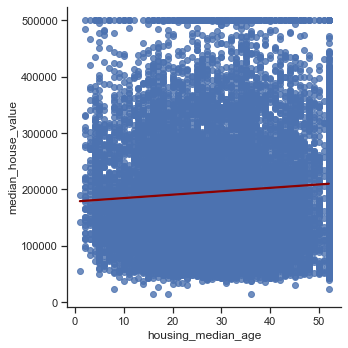

In [ ]:
sns.lmplot(x='housing_median_age', y='median_house_value', data=train_dataset2b, line_kws={'color': 'darkred'}, ci=False);

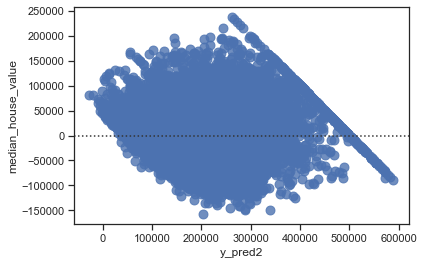

In [ ]:
sns.residplot(x="y_pred2", y="median_house_value", data=train_dataset2b, scatter_kws={"s": 80});


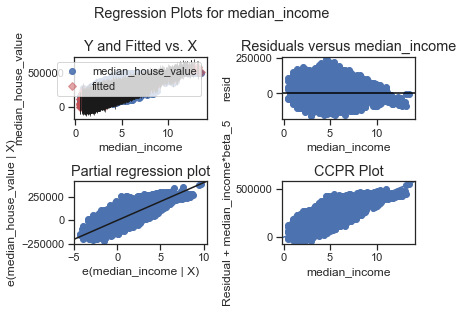

In [ ]:
# Regression diagnostics für Variable "median_income"
fig = sm.graphics.plot_regress_exog(lm4, "median_income")
fig.tight_layout(pad=1.0)

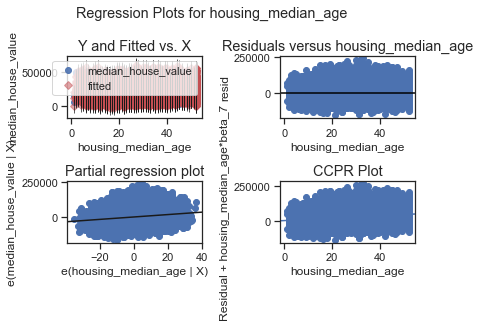

In [ ]:
# Regression diagnostics für Variable "housing_median_age"
fig = sm.graphics.plot_regress_exog(lm4, "housing_median_age")
fig.tight_layout(pad=1.0)

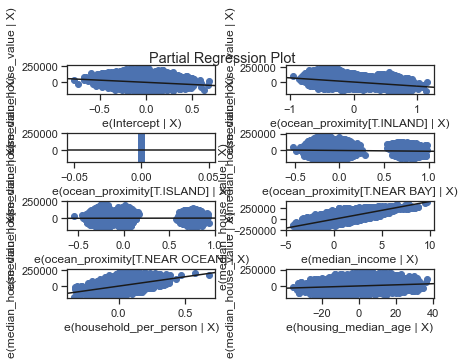

In [ ]:
# Regression diagnostics für alle Variablen
fig = sm.graphics.plot_partregress_grid(lm4)
fig.tight_layout(pad=0.1)

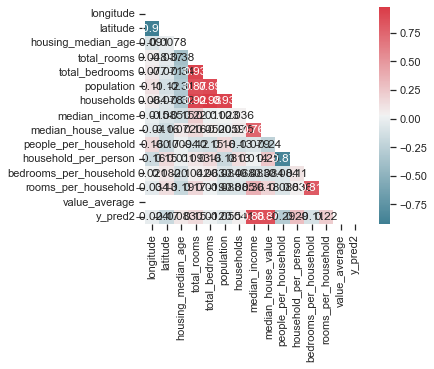

In [ ]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
corr = train_dataset2b.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12});

In [ ]:
# Validation with Test Data?

## 2. Lasso Regression

### 2.1 Lasso Regression mit scikit-learn

In [ ]:
# Erstellen der X und Y Variablen
y2 = train_dataset['median_house_value']
features = ['median_income', 'household_per_person', 'ocean_proximity', 'housing_median_age']
X2 = train_dataset[features]

#### Split Data

In [ ]:
# Data split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=10)

In [ ]:
# make list of numerical features (League_N, Division_W and NewLeague_N are categorcial) 
list_numerical = X2.drop(['ocean_proximity'], axis=1).columns


In [ ]:
list_numerical

Index(['median_income', 'household_per_person', 'housing_median_age'], dtype='object')

#### Standardization

Lasso performs best when all numerical features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This means it is important to standardize our features. We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation. This so called standard score  for an observation  is calculated as:

 
where:

x is an observation in a feature

 is the mean of that feature

s is the standard deviation of that feature.

To avoid data leakage, the standardization of numerical features should always be performed after data splitting and only from training data. Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. Note that we don’t standardize our dummy variables (which only have values of 0 or 1).

#### Lasso - Model

In [ ]:

# Erstellen der Pipeline mit Lasso Modell
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=1))
                        ])

In [ ]:
# Fitten von Pipeline/Modell
lasso_pipe.fit(X_train2, y_train2)


C:\Users\olive\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+12, tolerance: 1.533e+10



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A55640>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A51640>)])),
                ('lasso', Lasso(alpha=1))])

In [ ]:
#categorical_features = ['ocean_proximity']

In [ ]:
# Erstellen einer Liste aller Feature Namen
feature_names = np.concatenate((list_numerical.to_numpy(), lasso_pipe.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out()))
feature_names

array(['median_income', 'household_per_person', 'housing_median_age',
       'x0_<1H OCEAN', 'x0_INLAND', 'x0_ISLAND', 'x0_NEAR BAY',
       'x0_NEAR OCEAN'], dtype=object)

#### Lasso - Model Evaluation

In [ ]:
print('R squared training set', round(lasso_pipe.score(X_train2, y_train2)*100, 2))
print('R squared test set', round(lasso_pipe.score(X_test2, y_test2)*100, 2))

R squared training set 65.86
R squared test set 65.53


In [ ]:
# Training data
pred_train = lasso_pipe.predict(X_train2)
mse_train = mean_squared_error(y_train2, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred_test = lasso_pipe.predict(X_test2)
mse_test =mean_squared_error(y_test2, pred_test)
print('MSE test set', round(mse_test, 2))

MSE training set 4575965321.24
MSE test set 4647160878.2


#### Lasso - k-fold cross validation

find best value for alpha

In [ ]:

# Create pipeline with model
lassoCV_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassoCV', LassoCV(cv=5, random_state=0, max_iter=10000))
                        ])

In [ ]:
# Fit model
lassoCV_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A55640>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A51640>)])),
                ('lassoCV', LassoCV(cv=5, max_iter=10000, random_state=0))])

In [ ]:
lassoCV_pipe.named_steps['lassoCV'].alpha_

79.87760954506325

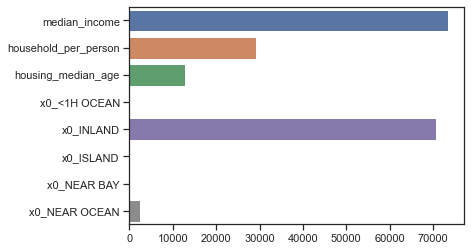

In [ ]:
# get absolute values of coefficients
importance = np.abs(lassoCV_pipe.named_steps['lassoCV'].coef_)

sns.barplot(x=importance, 
            y=feature_names);

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from time import time

tic_fwd = time()

sfs_forward = SequentialFeatureSelector(
    lassoCV_pipe, n_features_to_select=2, 
    direction="forward").fit(X_train2, y_train2)

toc_fwd = time()
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

C:\Users\olive\Anaconda\lib\site-packages\sklearn\base.py:561: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

#### Lasso - Lasso Best

In [ ]:
# Create pipeline with model
lassobest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassobest', Lasso(alpha=lassoCV_pipe.named_steps['lassoCV'].alpha_))
                            ])

In [ ]:
# Set best alpha

lassobest_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A55640>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024045A51640>)])),
                ('lassobest', Lasso(alpha=79.87760954506325))])

In [ ]:
print('R squared training set lasso best', round(lassobest_pipe.score(X_train2, y_train2)*100, 2))
print('R squared test set lasso best', round(lassobest_pipe.score(X_test2, y_test2)*100, 2))

R squared training set lasso best 65.77
R squared test set lasso best 65.52


In [ ]:
print('R squared training set lasso not best', round(lasso_pipe.score(X_train2, y_train2)*100, 2))
print('R squared test set lasso not best', round(lasso_pipe.score(X_test2, y_test2)*100, 2))

R squared training set lasso not best 65.86
R squared test set lasso not best 65.53


## 3. Splines

In [ ]:
y3 = train_dataset[['median_house_value']]
X3 = train_dataset[['median_income']]

In [ ]:
# data split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=10)

X_train3

median_income
17220         5.8411
8046          3.4605
14809         4.4777
19166         1.6685
4265          1.7306
...              ...
8282          3.4107
2305          4.7804
17874         3.4896
5754          7.4046
6574          3.8203

[11437 rows x 1 columns]

### 3.1 Splines with sclearn

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge


# Create pipeline with model
splines_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('splines', make_pipeline(SplineTransformer(n_knots=4, degree=3), 
                       Ridge(alpha=1)))
                        ])

In [ ]:
splines_pipe.fit(X_train3, y_train3)

y_pred = splines_pipe.predict(X_train3)

In [ ]:
import numpy as np

model_results(model_name = "spline")

NameError: name 'model_results' is not defined

In [ ]:
y3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16339 entries, 6517 to 17881
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  16339 non-null  float64
dtypes: float64(1)
memory usage: 771.3 KB


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create observations
x_new = np.linspace(X_test3.min(),X_test3.max(), 100)
# Make some predictions
pred = splines_pipe.predict(x_new)

# plot
sns.scatterplot(x=X_train3['median_income'], y=y_train3['median_house_value'])

plt.plot(x_new, pred, label='Cubic spline with degree=3', color='orange')
plt.legend();

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
print('R squared training set', round(splines_pipe.score(X_train3, y_train3)*100, 2))
print('R squared test set', round(splines_pipe.score(X_test3, y_test3)*100, 2))

R squared training set 48.87
R squared test set 49.51


### 3.2 Splines with Patsy

In [ ]:
# Generating cubic spline with 3 knots at 1, 4 and 7
transformed_x = dmatrix(
            "bs(train, knots=(1,4,7), degree=3, include_intercept=False)", 
                {"train": X_train3},return_type='dataframe')

In [ ]:
# Fitting generalised linear model on transformed dataset
spline2 = sm.GLM(y_train3, transformed_x).fit()

In [ ]:
# Training data
pred_train = spline2.predict(dmatrix("bs(train, knots=(1,4,7), include_intercept=False)", {"train": X_train3}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train3, pred_train, squared=False)

# Test data
pred_test = spline2.predict(dmatrix("bs(test, knots=(1,4,7), include_intercept=False)", {"test": X_test3}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test3, pred_test, squared=False)

# Save model results
model_results = pd.DataFrame(
    {
    "model": "Cubic spline (cs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

model_results

model    rmse_train     rmse_test
0  Cubic spline (cs)  82639.192957  82585.353147

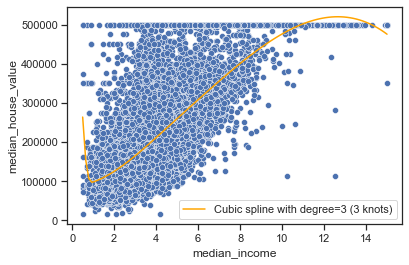

In [ ]:
# Create observations
xp = np.linspace(X_test3.min(),X_test3.max(), 100)
# Make some predictions
pred = spline2.predict(dmatrix("bs(xp, knots=(1,4,7), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train3['median_income'], y=y_train3['median_house_value'])

plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

### 3.3 Natural Spline with Patsy & Statsmodels

In [ ]:
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train3}, return_type='dataframe')

spline3 = sm.GLM(y_train3, transformed_x3).fit()

In [ ]:
# Training data
pred_train = spline3.predict(dmatrix("cr(train, df=3)", {"train": X_train3}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train3, pred_train, squared=False)

# Test data
pred_test = spline3.predict(dmatrix("cr(test, df=3)", {"test": X_test3}, return_type='dataframe'))
rmse_test = mean_squared_error(y_test3, pred_test, squared=False)

# Save model results
model_results_ns = pd.DataFrame(
    {
    "model": "Natural spline (ns)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

model_results_ns

model  rmse_train     rmse_test
0  Natural spline (ns)    83542.83  83554.449619

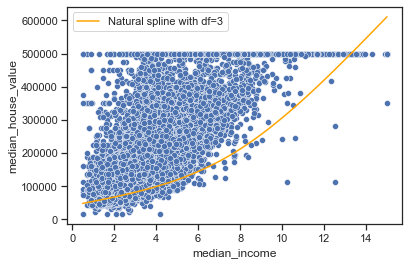

In [ ]:
# Make predictions
pred = spline3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))
xp = np.linspace(X_test3.min(),X_test3.max(), 100)
# plot
sns.scatterplot(x=X_train3['median_income'], y=y_train3['median_house_value'])
plt.plot(xp, pred, color='orange', label='Natural spline with df=3')
plt.legend();